In [1]:
source("~/r_utils/startup_r.R")
startup_r()


Startup complete: common libraries loaded!



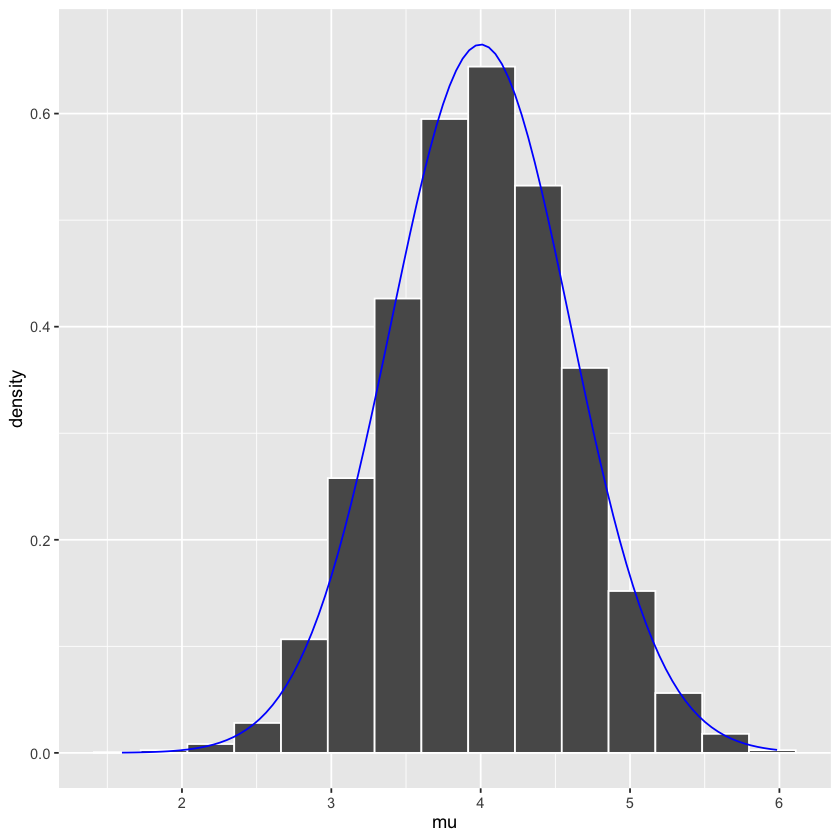

In [2]:
set.seed(84375)
mc_tour <- data.frame(mu = rnorm(5000, mean = 4, sd = 0.6))
ggplot(mc_tour, aes(x = mu)) +
    geom_histogram(aes(y = after_stat(density)), color = "white", bins = 15) +
    stat_function(fun = dnorm, args = list(4, 0.6), color = "blue")


# Metropolis Algorithm Implementation
- Prior u is ~N(0,1)
- Data varies normally around an unknown mean with sd 0.75
    - Y|mu ~ N(mu,0.75^2)
    - Outcome is observed at Y = 6.25
- True posterior is ~N(4,0.6^2)
- Proposal distribution is uniform with half window size w

## Metropolis workflow:
- Step 1: propose a new location conditioned on current location
- Step 2: Accept proposal proposal with probability based on likelihood ratio of proposed/current


In [57]:
# Define a function for a single iteration of metropolis for this model setup
# Input should be current location and window size for uniform proposal
# Output should be the next step in the chain

metro_1step <- function(current, w) {
    # Step 1: Propose
    proposal <- runif(n = 1, min = current - w, max = current + w)

    # Step 2: Accept/Reject
    # calculate current likelihood and prior
    current_llhd <- dnorm(x = 6.25, mean = current, sd = 0.75)
    current_prior <- dnorm(x = current, mean = 0, sd = 1)
    # calculate proposal likelihood and prior
    proposal_llhd <- dnorm(x = 6.25, mean = proposal, sd = 0.75)
    proposal_prior <- dnorm(x = proposal, mean = 0, sd = 1)
    # calculate proposal probability
    prop_prob <- min(1, (proposal_llhd * proposal_prior) / (current_llhd * current_prior))
    # accept or reject based on propsal prob
    next_stop <- sample(x = c(proposal, current), size = 1, prob = c(prop_prob, 1 - prop_prob))

    return(data.frame(proposal, prop_prob, next_stop))
}


metro_1step(current = 3, w = 1)


proposal,prop_prob,next_stop
<dbl>,<dbl>,<dbl>
3.338507,1,3.338507


In [71]:
n_samples <- 10000
start <- 10
w_size <- 5
mcmc_res <- data.frame(step = 1:n_samples)

for (i in 1:n_samples) {
    step_res <- metro_1step(current = start, w = w_size)
    mcmc_res[i, "proposal"] <- step_res$proposal
    mcmc_res[i, "prop_prob"] <- step_res$prop_prob
    mcmc_res[i, "next_stop"] <- step_res$next_stop
    start <- step_res$next_stop
}

head(mcmc_res)


,step,proposal,prop_prob,next_stop
,<int>,<dbl>,<dbl>,<dbl>
1,1,13.548619,5.229856e-34,10.000000
2,2,7.599711,1.000000e+00,7.599711
3,3,7.287605,1.000000e+00,7.287605
4,4,2.451079,1.000000e+00,2.451079
5,5,2.766898,1.000000e+00,2.766898
6,6,7.573406,1.640355e-07,2.766898


NULL

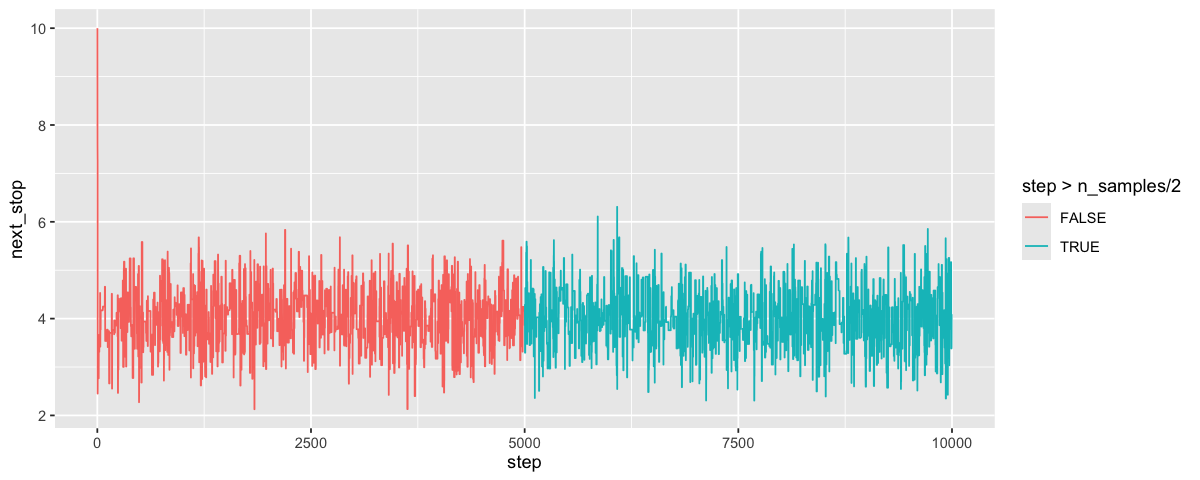

In [72]:
fig.size(4, 10)
mcmc_res %>%
    ggplot(aes(x = step, y = next_stop, col = step > n_samples / 2)) +
    geom_line()


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


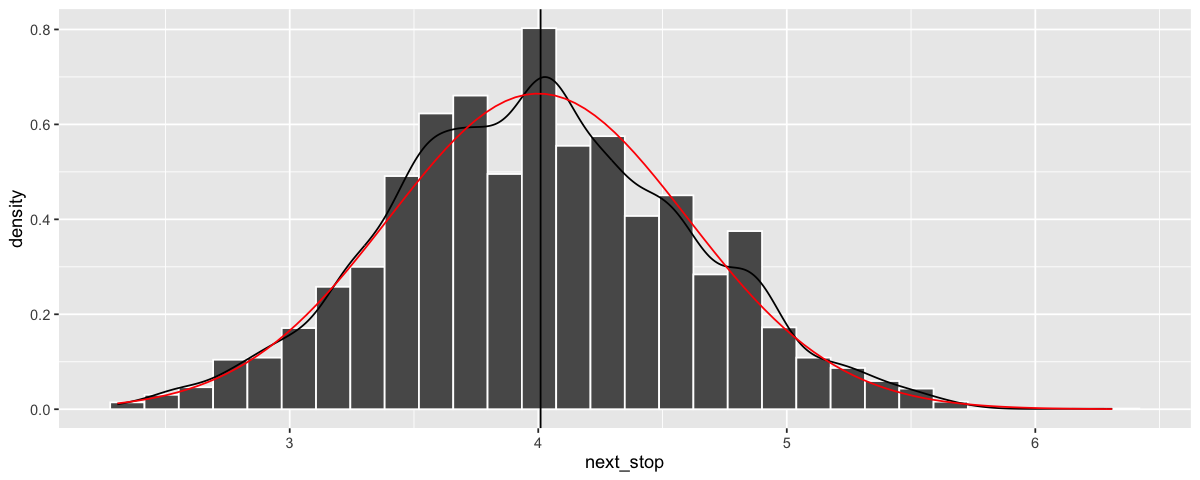

In [73]:
# now lets take a look at the res after burn in

mcmc_res %>%
    filter(step > n_samples / 2) %>%
    ggplot(aes(x = next_stop)) +
    geom_histogram(aes(y = after_stat(density)), col = "white") +
    geom_density() +
    geom_vline(xintercept = mean(mcmc_res$next_stop)) +
    stat_function(fun = dnorm, args = list(4, 0.6), color = "red")


In [74]:
mean(mcmc_res$next_stop)
sd(mcmc_res$next_stop)
# true mean 4, true sd 0.6


[1] 4.00945

[1] 0.6047265